# Model reproduction

## Base model description

### Mosquito ODE

![](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4662560/bin/nihms667303f2.jpg)

In the above, the subscript $v$ stands for vector/mosquito.

- $\lambda$ is the average _force of infection to mosquitos_ — the rate of infection for each mosquito per unit time
    - Defined as the product of: (1) The average number of bites per mosquito, (2) The probability that a bite is on an infectious host, and (3) The probability of transmission per bite
- $\nu$ is the rate at which mosquitoes move from the incubating period to infectious
- $\mu$ is the per-capita rate of death

$$
\begin{align*}
\frac{dS}{dt} &= h(N,t)-\lambda(t) S - \mu S \\
\frac{dE}{dt} &= \lambda(t) S - \nu E - \mu E \\
\frac{dI}{dt} &= \nu E - \mu I
\end{align*}
$$

Where:
- $h(N,t)$ is the per-capita emergence function, defined as $\left(\psi-\frac{r\cdot N}{K}\right)N$
    - $\psi$ is the natural per-capita emergence rate of mosquitoes in the absence of _density dependence_
    - $K$ is the carrying capacity of the mosquitoes in the patch
    - $r=\psi-\mu$ is the intrinsic growth rate of mosquitoes in the absence of density dependence

The expression for change in total mosquito population over time is given by:

$$
\begin{align*}
\frac{dN}{dt}&=\left(\psi-\frac{rN}{K}\right)N - \mu N \\ &= r\left(1-\frac{N}{K}\right)N
\end{align*}
$$

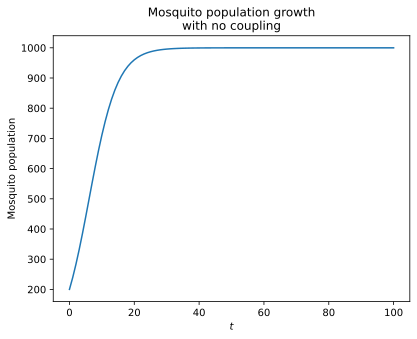

In [21]:
N = 200
K = 1000
r = 0.3 - (1/14)

t_max = 100
t = np.linspace(0, t_max, t_max+1)

def mosquito_rates(N, t):
    dN = r*(1 - N/K)*N
    
    return dN

res = integrate.odeint(mosquito_rates, 
                       [N],
                       t)
plt.plot(t, res)

plt.xlabel(r"$t$")
plt.ylabel("Mosquito population")
plt.title("Mosquito population growth\nwith no coupling")

plt.show()

**Biting and infection rates (where the coupling happens)**

There are two parameters for "forces of infection" that couple the ABM with the ODE:
1. The rate at which vectors (mosquitos) are infected: $\lambda_v$
2. The rate at which hosts (humans) are infected: $\lambda_{h,j}$

where $v$ denotes vectors, $h$ denotes hosts, $j$ denotes activity.

Reminder that these are different for each patch, hereafter denoted as superscript $k$. This is communicated to the ABM, which is combined with each agent's mosquito exposure modifier $\alpha_j$.

---

The force of infection on mosquitos is defined as:

$$\lambda_v = b_v\cdot \beta_{vh}\cdot \left(\frac{\hat{I}_h}{\hat{N}_h}\right)$$

Where:
- $b_v=\frac{\sigma_v N_v \sigma_h \hat{N}_h}{\sigma_v N_v + \sigma_h \hat{N}_h}$ is the number of bites one mosquito has per unit times
    - $\sigma_v$ is the total number of successful bites a single mosquito "would like to have" per unit time; depends on weather, species
    - $\sigma_h$ is the number of bites a host can sustain over a given time; depends on **exposed skin area**, location. <mark>NOTE: mitigation strategies would alter this parameter</mark>
    - $N_v$ is the number of mosquitoes in the patch
- $\beta_{vh}$ is the probability of contracting the pathogen after biting an infectious host
- $\hat{I}_h=\sum_j{\alpha_j I_{h,j}}$ is the scaled infection population in the patch
- $\hat{N}_h=\sum_j{\alpha_j N_{h,j}}$ is the number of hosts in the patch scaled by availability to be bitten

---

The force of infection on hosts is defined as:

$$\lambda_{h,j}(t) = b_{h,j} \cdot \beta_{hv} \cdot \left(\frac{I_v}{N_v}\right)$$

Where:
- $b_{h,j}=\alpha_j \left(\frac{b}{N_v}\right)$
- $\beta_{hv}$ is the probability of transmission from vector to host
- $N_v/I_v$ is the proportion of infectious mosquitoes

### ABM

In the ABM, agents are on a network, where nodes correspond to activities $j$. Nodes have a corresponding patch $k$ from which they are coupled with the corresponding ODE model $\mathcal{M}_v^{(k)}$. The example given by Manore et al. in their paper is the following:

![](https://www.tandfonline.com/cms/asset/9929aee1-668b-4ee8-9ec0-a6021b2790c4/tjbd_a_1005698_f0001_c.jpg)

## Reproducing the model

**Initialisation procedure**:

0. In my case, I am reproducing the figure above.
1. Assign ? agents random locations on these nodes.
2. Assign ? agents susceptible, ? infected.
    
**Scheduling**:

0. Initialise model.
1. Randomly assign susceptible agent locations.
2. Randomly infect a number of agents.
3. Advance time in $\Delta t$ increments:
    1. Update infection status of agents.
    2. Move agents.
4. Stop once condition is reached


**Classes**:

- Agent
    - MovementModel
- Network
    - Node
        - Activity
        - Patch
            - MosquitoModel
- Model

<mark>**Open questions**</mark>:
- Is $\Delta t$ time in activity, or time step?
    - I think time step.

### Required libraries

In [111]:
import numpy as np
import networkx as nx
from enum import Enum

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from collections.abc import Iterable
from typing import Callable

### Custom types

An enum type for disease states helps me switch on these easier.

In [62]:
class DiseaseState(Enum):
    SUSCEPTIBLE = 0
    EXPOSED     = 1
    INFECTED    = 2
    RECOVERED   = 3

### Classes

---

`Agent`: an agent
- Properties:
    - [X] Have disease state ($S$, $E$, $I$, or $R$)
    - [X] A current node
    - [X] A movement model
- Methods:
    - [X] Move (depends on movement model)
    - [X] Update disease state
    
`MovementModel`: logic to move agents
- Properties:
- Methods:
    - [X] Move

`Node`: a location agents are in
- Properties
    - [X] ID (int)
    - [X] Patch
    - [X] Activity
- Methods
    - [X] Calculate infection rate for hosts, $\lambda_{h,j}=\alpha_j b_h \cdot \beta_{hv} \cdot \frac{I_v}{N_v}$

`Activity`: the activity the agent is carrying out
- Properties
    - [X] $\alpha_j\in[0,1]$, the exposure parameter that determines relative risk of agent being bitten by a mosquito
- Methods

`Patch`: the area covered by a mosquito patch
- Properties
    - [X] $k$, the ID of the patch
    - [X] `MosquitoModel`, the ODE system of the patch
    - [X] $K_v$, the carrying capacity (max number of mosquitoes) of the patch
- Methods
    - [X] Calculate patch-specific values:
        - $S_h, E_h, I_h, R_h$ and $\hat{S}_h, \hat{E}_h, \hat{I}_h, \hat{R}_h$
        - number of contacts for patch $b=\frac{\sigma_v N_v \sigma_h \hat{N}_h}{\sigma_v N_v + \sigma_h \hat{N}_h}$
        - biting rate of mosquitos per unit time for patch $b_v=b/N_v$
        - biting rate of hosts per unit time for patch $b_h=b/\hat{N}_h$
    - [X] Calculate infection rate for mosquitoes, $\lambda_v=b_v \cdot \beta_{vh} \cdot \frac{\hat{I}_h}{\hat{N}_h}$
    
`Model`: the model of the system
- Properties
    - [X] $\Delta t$, the time step
    - [X] $\nu_h$, the rate of becoming infected after exposed for hosts
    - [X] $\mu_h$, the rate of becoming recovered after infected for hosts
- Methods
    - [ ] `run`: run the model until a stopping condition
    - [ ] `tick`: progress the model forward by one time step
    
`MosquitoModel`: ODE model for a patch
- Properties
    - Disease state ($S$, $E$, $I$)
    - $\nu_v$, the rate of becoming infectious from incubation
    - $\mu_v$, the per-capita rate at which mosquitoes die
    - $S_v$, the number of susceptible mosquitoes
    - $E_v$, the number of exposed mosquitoes
    - $I_v$, the number of infectious mosquitoes
    - $\phi_v$, the per-capita emergence rate of mosquitoes per time step
    - $\sigma_v$, the number of times one mosquito would want to bite a host per time step if hosts were freely available
    - $\sigma_h$, the maximum number of mosquito bites an average host can sustain per time step
    - $\beta_{hv}$, the probability of transmission from an infectious mosquito to a susceptible host given contact
    - $\beta_{vh}$, the probability of transmission from an infectious host to a susceptible mosquito given contact
- Methods
    - Solve the ODE system forward
    - Get force of infection on agents

In [ ]:
movement_dist=lambda : np.random.lognormal(1, .001)
nu_h_dist=lambda : np.random.lognormal(1/5, .001)
mu_h_dist=lambda : np.random.lognormal(1/6, .001)

In [170]:
class Model(ABC):
    """Abstract class representing a custom instance of the hybrid ABM adapted from Manore et al."""
    
    @abstractmethod
    def run(self):
        pass
    
    @abstractmethod
    def tick(self):
        pass


class BaselineModel(Model):
    """The baseline model from Manore et al."""
    def __init__(self,
                 k: int,
                 timestep: float,
                 movement_dist: Callable[None, float],
                 sigma_h_arr: np.ndarray,
                 sigma_v_arr: np.ndarray,
                 K_v_arr: np.ndarray,
                 patch_densities: np.ndarray,
                 phi_v_arr: np.ndarray,
                 beta_hv_arr: np.ndarray,
                 beta_vh_arr: np.ndarray,
                 nu_v_arr: np.ndarray,
                 mu_v_arr: np.ndarray,
                 r_v_arr: np.ndarray,
                 num_locations: int,
                 edge_prob: float,
                 num_agents: int,
                 initial_infect_proportion: float,
                 nu_h_dist: Callable[None, float],
                 mu_h_dist: Callable[None, float],
                 total_time: float,
                 mosquito_r_k_timestep: float) -> None:
        """
        Parameters
        ----------
        k : int
            Number of patches.
        timestep : float
            Time (in days) that one tick of the model represents, $\Delta t$.
        movement_dist : Callable[None, float]
            The distribution to draw agent $\rho$, the propensity to move nodes, from.
        sigma_h_arr : vector of size $k$
            $\sigma_h$ (the maximum number of mosquito bites an average host can sustain per time step) values for each patch.
        sigma_v_arr : vector of size $k$
            $\sigma_v$ (the number of times one mosquito would want to bite a host per time step if hosts were freely available) values for each patch.
        K_v_arr : vector of size $k$
            Carrying capacities for each patch.
        patch_densities : vector of size $k$
            Densities for each patch.
        phi_v_arr : vector of size $k$
            Emergence rates of mosquitoes for each patch.
        beta_hv_arr : vector of size $k$
            Probability of mosquito-to-host transmission for each patch.
        beta_vh_arr : vector of size $k$
            Probability of host-to-mosquito transmission for each patch.
        nu_v_arr : vector of size $k$
            Mosquito E->I rate for each patch.
        mu_v_arr : vector of size $k$
            Mosquito death rate per patch.
        num_locations : int
            Number of locations/nodes in the graph.
        edge_prob : float
            Probability of connecting two edges in the graph (p).
        num_agents : int
            Number of agents/hosts in the simulation.
        initial_infect_proportion : float
            Proportion of agents initially infected.
        nu_h_dist : Callable[None, float]
            Distribution to draw $\nu_h$ from for each agent (E->I rate).
        mu_h_dist : Callable[None, float]
            Distribution to draw $\mu_h$ from for each agent (I->R rate).
        total_time : float
            Time (in days) to run simulation for.
        mosquito_timestep : float
            Not sure yet - suspect "RK" = Runge-Kutta.
        """
        # Assign model-specific parameters
        self.time = 0.0
        self.timestep = timestep
        self.total_time = total_time
        self.mosquito_timestep = mosquito_timestep
        self.movement_model = BaselineMovementModel(model=self)
        
        self.agents:  List[Agent] = [None] * num_agents
        self.nodes:   List[Node]  = [None] * num_locations
        self.patches: List[Patch] = [None] * k
        
        # NOTE: tracking
        self.num_infected = 0
        
        
        # Initialise network — Erdos-Renyi with n, p
        self.graph = nx.erdos_renyi_graph(num_locations, edge_prob)
        
        
        # Initialise nodes — distributed according to patch density
        node_patch_ids = np.random.choice(k, num_locations, p=patch_densities) # maps node id -> patch id
        activity = Activity(activity_id=0, alpha=1)                            # only one activity in baseline model
        
        for node_id in range(num_locations):
            node = Node(node_id=node_id, activity=activity)
            self.nodes[node_id] = node
            self.graph.nodes[node_id]["node"] = node
        
        
        # Initialise patches
        for patch_id in range(k):
            patch = Patch(
                k=patch_id,
                K_v=K_v_arr[patch_id],
                sigma_v=sigma_v_arr[patch_id],
                sigma_h=sigma_h_arr[patch_id],
                phi_v=phi_v_arr[patch_id],
                beta_hv=beta_hv_arr[patch_id],
                beta_vh=beta_vh_arr[patch_id],
                nu_v=nu_v_arr[patch_id],
                mu_v=mu_v_arr[patch_id],
                r_v=r_v_arr[patch_id],
                model=self,
                nodes=self.nodes[np.where(node_patch_ids == patch_id)]
            )
            self.patches[patch_id] = patch
        
        
        # Initialise agents
        agent_disease_states = np.random.choice(
            [DiseaseState.SUSCEPTIBLE, DiseaseState.INFECTED],
            size=num_agents,
            p=[1-initial_infect_proportion,initial_infect_proportion]
        )
        for i in range(num_agents):
            agent = Agent(state=agent_disease_states[i],
                                   node=np.random.choice(num_locations), # chosen with equal probability
                                   movement_rate=movement_dist(),
                                   movement_model=self.movement_model,
                                   nu_h=nu_h_dist(),
                                   mu_h=mu_h_dist(),
                                   model=self
                                  )
            self.agents[i] = agent
            self.nodes[agent.node].add_agent(agent)
            
        # Set initial variables for mosquito patches
        for patch in self.patches:
            patch.update_patch_values() # NOTE: shouldn't exist. Instead, create a `tick()` method that does this + advances patch model.
    
    
    def tick(self) -> List[Any]:
        """Progress the model forward in time by the time step."""
        # (1) Update disease status of vectors and then hosts
        for patch in self.patches:
            patch.tick()
        
        # (2) Move agents randomly
        for agent in self.agents:
            agent.move()
            
        return []
            
    
    def run(self) -> List[Any]:
        """Run the model until a certain number of time steps."""
        res = [] # TODO: refactor this into a pandas df where 1 row = tick, df = run
        
        while self.time < self.total_time:
            res.append(self.tick())
            self.time += self.timestep
        
        return res

In [ ]:
class MosquitoModel:
    """Class representing a system of ODEs to be solved for a patch model."""
    def __init__(self,
                 N0: float,
                 K_v: float,
                 phi_v: float,
                 r_v: float,
                 mu_v: float,
                 nu_v: float,
                 time: float,
                 timestep: float,
                 solve_timestep: float
                ):
        self.S, self.I, self.E = N0, 0, 0
        self.N_v = self.S + self.I + self.E
        self.K_v = K_v
        self.phi_v = phi_v
        self.r_v = r_v
        self.mu_v = mu_v
        self.nu_v = nu_v
        
        self.lambda_v = None
    
    
    def tick(self, lambda_v):
        """Solve the mosquito model forward in time by the required amount."""
        self.lambda_v = lambda_v
        
        t   = np.arange(time, time+timestep+solve_timestep, solve_timestep)
        res = integrate.odeint(self._sei_rates,
                               (self.S, self.E, self.I),
                               t)
        self.N_v = res.sum()
        self.S, self.E, self.I = res.T
    
    
    def _sei_rates(self, X, t) -> np.ndarray:
        S, E, I = X
        N_v     = X.sum()
        
        h_v = (self.phi_v - self.r_v*N_v/self.K_v)*N_v
        
        dS = h_v - self.lambda_v * S - self.mu_v * S
        dE = self.lambda_v * S - self.nu_v * E - self.mu_v * E
        dI = self.nu_v * E - self.mu_v * I
        
        return np.array([dS, dE, dI])

In [ ]:
class Patch:
    """Represents an area covering nodes with a corresponding mosquito 'cloud'."""
    def __init__(self,
                 k: int,
                 K_v: float,
                 sigma_v: float,
                 sigma_h: float,
                 phi_v: float,
                 beta_hv: float,
                 beta_vh: float,
                 nu_v: float,
                 mu_v: float,
                 r_v: float,
                 model: Model,
                 nodes: Set[Node]=None) -> None:
        self.k = k
        self.K_v = K_v
        self.sigma_v = sigma_v
        self.sigma_h = sigma_h
        self.model = model
        
        self.nodes: Set[Node] = set() if nodes is None else nodes
        
        self.mosquito_model = MosquitoModel(N0=K_v,
                                            K_v=K_v,
                                            phi_v=phi_v,
                                            r_v=r_v,
                                            mu_v=mu_v,
                                            nu_v=nu_v,
                                            time=model.time,
                                            timestep=model.timestep,
                                            solve_timestep=model.mosquito_timestep
                                            )
        
        # derived patch-specific values
        self.S_h = None
        self.E_h = None
        self.I_h = None
        self.R_h = None
        self.N_h = None
        
        self.S_hat_h = None
        self.E_hat_h = None
        self.I_hat_h = None
        self.R_hat_h = None
        self.N_hat_h = None
        
        self.b   = None
        self.b_v = None
        self.b_h = None


    # TODO: delete this.
    # def add_nodes(self, nodes_to_add: Iterable[int]) -> None:
    #     """Add nodes to the patch."""
    #     self.nodes = set.union(self.nodes, set(nodes_to_add))
    
    
    def tick(self) -> np.ndarray:
        """Advance the patch model by one time step."""
        # Update patch values from ABM (agent statistics)
        self._update_patch_values()
        
        # Advance the patch model (EBM)
        self.mosquito_model.tick(self.get_force_on_vectors())
        
        # For each node in this patch, progress disease states of agents
        for node in self.nodes:
            for agents in self.agents:
                agent.update_state(node.get_force_on_hosts(b_h=self.b_h, beta_hv=self.beta_hv, I_v=self.mosquito_model.I, N_v=self.mosquito_model.N_v))


    def _update_patch_values(self) -> None:
        """Update the internal values of a patch."""
        seirs, seirs_hat = self._count_agents_in_patch()
        self.N_h, self.N_hat_h = seirs.sum(), seirs_hat.sum()
        
        [self.S_h, self.E_h, self.I_h, self.R_h] = seirs
        [self.S_hat_h, self.E_hat_h, self.I_hat_h, self.R_hat_h] = seirs_hat
        
        m = self.mosquito_model # for brevity
        
        self.b   = (self.sigma_v * m.N_v * self.sigma_h * self.N_hat_h)/(self.sigma_v * m.N_v + self.sigma_h * self.N_hat_h)
        self.b_v = self.b/m.N_v
        self.b_h = self.b/m.N_hat_h


    def _count_agents_in_patch(self) -> (int, int, int, int, float, float, float, float):
        """Count agents in this patch."""
        seirs     = np.array([0, 0, 0, 0])
        seirs_hat = np.array([0, 0, 0, 0])
        
        for node in self.nodes:
            cur_seirs = np.array([0, 0, 0, 0])
            
            for agent in self.agents:
                match agent.state:
                    case DiseaseState.SUSCEPTIBLE:
                        cur_seirs[0] += 1
                    case DiseaseState.EXPOSED:
                        cur_seirs[1] += 1
                    case DiseaseState.INFECTED:
                        cur_seirs[2] += 1
                    case DiseaseState.RECOVERED:
                        cur_seirs[3] += 1

            seirs     += cur_seirs
            seirs_hat += node.activity.alpha * cur_seirs
        
        return seirs, seirs_hat
    
    
    def get_force_on_vectors(self) -> float:
        """Calculate the force of infection on vectors for this patch (lambda_v)."""
        return self.b_v * self.model.beta_vh * (self.I_hat_h/self.N_hat_h)

In [77]:
class Activity:
    """Class to define an activity."""
    def __init__(self, activity_id: int, alpha: float) -> None:
        self.activity_id = activity_id
        
        assert alpha >= 0 and alpha <= 1, "Alpha must be in [0,1]"
        self.alpha = alpha

In [ ]:
class Node:
    """A class representing a location (node) in the network model."""
    def __init__(self, node_id: int, activity: Activity, agents: Set[Agent]=None) -> None:
        self.node_id = node_id
        self.activity= activity
        
        self.agents: Set[Agent]  = set() if agents is None else agents
        
        
    def get_force_on_hosts(self, b_h: float, beta_hv: float, I_v: float, N_v: float) -> float:
        """Calculate the force of infection on hosts/agents for this node (lambda_{h,j})."""
        return (self.activity.alpha * b_h) * beta_hv * (I_v/N_v)
    
    
    def add_agent(self, agent: Agent) -> None:
        """Add an agent to the node."""
        self.agents.add(agent)
    
    
    def remove_agent(self, agent: Agent) -> None:
        """Remove an agent to the node."""
        self.agents.remove(agent)

In [ ]:
class Agent:
    """A class representing an agent on a network."""
    def __init__(self,
                 state: DiseaseState,
                 node: int,
                 movement_rate: float,
                 movement_model: MovementModel,
                 nu_h: float,
                 mu_h: float,
                 model: Model) -> None:
        self.state = state
        self.node  = node
        self.model = model
        
        self.movement_rate  = movement_rate
        self.movement_model = movement_model
    
    
    def move(self) -> None:
        """Moves the agent randomly."""
        self.movement_model.move_agent(self, self.movement_rate)
        
        
    def update_state(self, lambda_hj) -> None:
        """Updates agent SEIR states stochastically."""
        match self.state:
            r = np.random.random()
            
            case DiseaseState.SUSCEPTIBLE:
                if r < 1 - np.exp(- self.model.timestep * lambda_hj):
                    self.state = DiseaseState.EXPOSED
            case DiseaseState.EXPOSED:
                if r < 1 - np.exp(- self.model.timestep * self.nu_h):
                    self.state = DiseaseState.INFECTED
                    # NOTE: tracking
                    self.model.num_infected += 1
            case DiseaseState.INFECTED:
                if r < 1 - np.exp(- self.model.timestep * self.mu_h):
                    self.state = DiseaseState.RECOVERED
            case _:
                pass

In [66]:
class MovementModel(ABC):
    """Abstract class representing the logic to make an agent move on a network."""
    
    @abstractmethod
    def move_agent(self):
        pass
    
    
class BaselineMovementModel(MovementModel):
    """A baseline movement model as described in Manore et al."""
    def __init__(self, model: Model) -> None:
        self.model = model
        
        
    def move_agent(self, agent: Agent, rho: float) -> None:
        """Move an agent with probability 1 - e^{- delta t * rho}"""
        if np.random.random() < 1 - np.exp(-self.model.timestep*rho):
            # An agent moves to a connected node uniformly
            new_node = np.random.choice(model.graph.adj[agent.node.node_id])
            
            model.graph.adj[agent.node.node_id]["node"].remove_agent(agent)
            model.graph.adj[new_node]["node"].add_agent(agent)
            
            agent.node = new_node

NameError: name 'Model' is not defined

In [32]:
G = nx.erdos_renyi_graph(10, .5)

In [33]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))

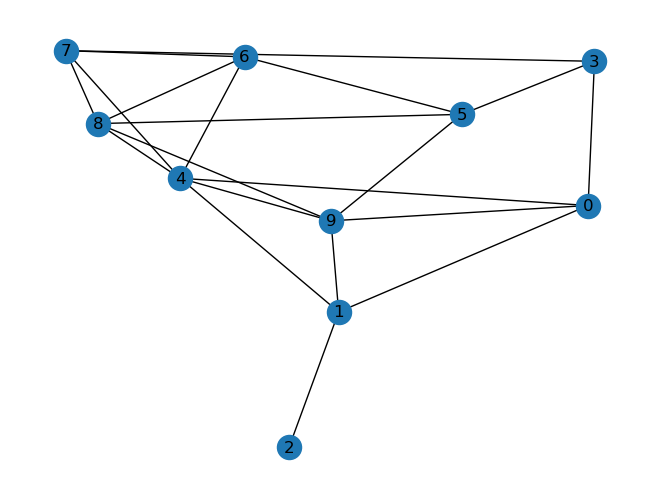

In [41]:
nx.draw(G, with_labels=True)

In [85]:
G.nodes[0]["node"] = "test"

In [1]:
import numpy as np
from enum import Enum
 


Season.SPRING
SPRING
1
<enum 'Season'>
<Season.SPRING: 1>
[<Season.SPRING: 1>, <Season.SUMMER: 2>, <Season.AUTUMN: 3>, <Season.WINTER: 4>]
